In [1]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

from os import PathLike
from IPython.display import display
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
from typing import cast, Tuple
from random import randint

from ba_dev.dataset import MammaliaDataSequence, MammaliaDataImage
from ba_dev.transform import ImagePipeline, BatchImagePipeline
from ba_dev.utils import load_path_yaml
from ba_dev.eval_helpers import *

set_custom_plot_style()
cm = 1 / 2.54

redo_all = True
export = True

eval = MammaliaEval(
    path_config='../../data/path_config.yml',
    metrics=['balanced_accuracy_score'],
    force_metrics=False
    )

# paths = load_path_yaml('../../data/path_config.yml')

# best_model = LoadRun(
#     log_path=paths['complete_models'] / 'efficientnet_b0_v4_pretrained_cross_val',
#     paths=paths
#     )


Loading pre-calculated metrics from file...


In [10]:
df = eval.image_df.copy()

agg_df = df.groupby("seq_id").agg(
    items=("seq_id", "count"),
    conf_zero=("conf", lambda x: (x == 0).sum())
).reset_index()

mask = agg_df[(agg_df["items"] == 6) & (agg_df["conf_zero"] == 2)]

df_filtered = df[df["seq_id"].isin(mask["seq_id"])]

seq_id_list = df_filtered["seq_id"].unique().tolist()

i = 0

seq_id: 1000960


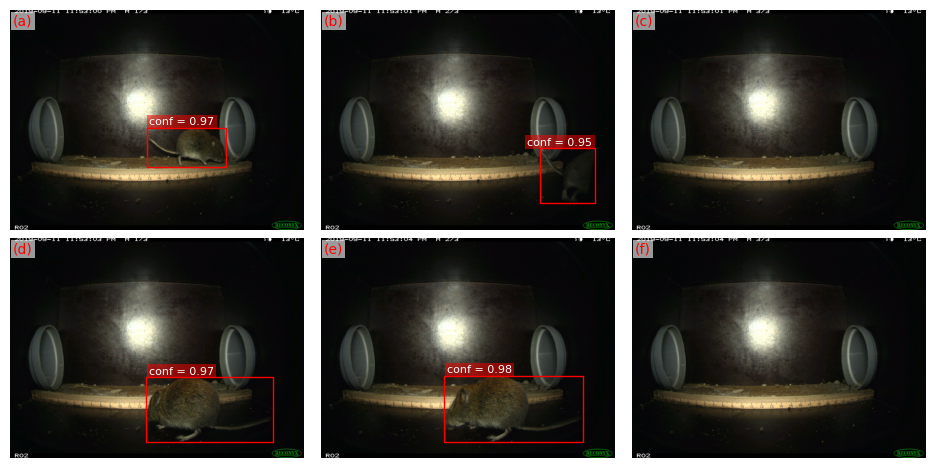

In [59]:
current_seq_id = seq_id_list[i]
chunk = df_filtered[df_filtered["seq_id"] == current_seq_id]
i += 1
print(f'seq_id: {current_seq_id}')
fig = plot_series_of_images(
    df=chunk, 
    dataset_path=eval.paths['dataset'], 
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=800
    )
display(fig)

In [ ]:
no_detect_selection = [255071, 141627, 381794, 30629, 95859, 6342, 24194, 47543, 29652, 20230, 16311, 144673, 71324, 5876, 29904, 89298, 65422]

false_positive_selection = [65422, 71324, 89298, 141627, 29904, 144673, 381794, 47543, 20230]

snail_images = [119992, 119993, 127010, 117471, 83765, 209198, 227109, 205311, 205344, 205345, 372009, 390188, 386088, 272372, 272377, 272378, 289393, 340151, 350399]

In [ ]:
df=eval.best_model.full_predicted_set.copy()

ordered_selection = [119992, 119993, 127010, 117471, 83765, 209198, 227109, 205311, 205344, 205345, 372009, 390188, 386088, 272372, 272377, 272378, 289393, 340151, 350399]
df_filtered = df[df['idx'].isin(ordered_selection )]
df_filtered = df_filtered.set_index('idx').loc[ordered_selection ].reset_index()

fig = plot_series_of_images(
    df=df_filtered, 
    dataset_path=eval.paths['dataset'], 
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=800
    )
    
display(fig)

NameError: name 'false_positive_selection' is not defined

In [70]:
df = eval.best_model.full_predicted_set.copy()

df_correct = df[df['correct'] == True]
df_incorrect = df[df['correct'] == False]

det_conf = df_correct['conf']
class_conf = df_correct['probs_max']

In [77]:
from scipy.stats import spearmanr

# Example: two lists or arrays of values
rho, p_value = spearmanr(det_conf, class_conf)
print(f'roh = {rho}')
print(f'p_value = {p_value}')

roh = 0.0923209340037485
p_value = 0.0


In [86]:
from scipy.stats import spearmanr


df = eval.best_model.full_predicted_set.copy()

for correct in [True, False]:

    subset = df[df['correct'] == correct]

    det_conf = subset['conf']
    class_conf = subset['probs_max']

    if correct:
        print('Correct predictions:')
    else:
        print('Incorrect predictions:')

    rho, p_value = spearmanr(det_conf, class_conf)
    print(f'rho = {rho}')
    print(f'p_value = {p_value}')

Correct predictions:
rho = 0.0923209340037485
p_value = 0.0
Incorrect predictions:
rho = 0.27581401763858365
p_value = 2.970009722854706e-39


In [75]:
from scipy.stats import kendalltau

tau, p_value = kendalltau(det_conf, class_conf)
print(f"Kendall's tau = {tau:.4f}, p = {p_value:.4g}")

Kendall's tau = 0.0753, p = 0


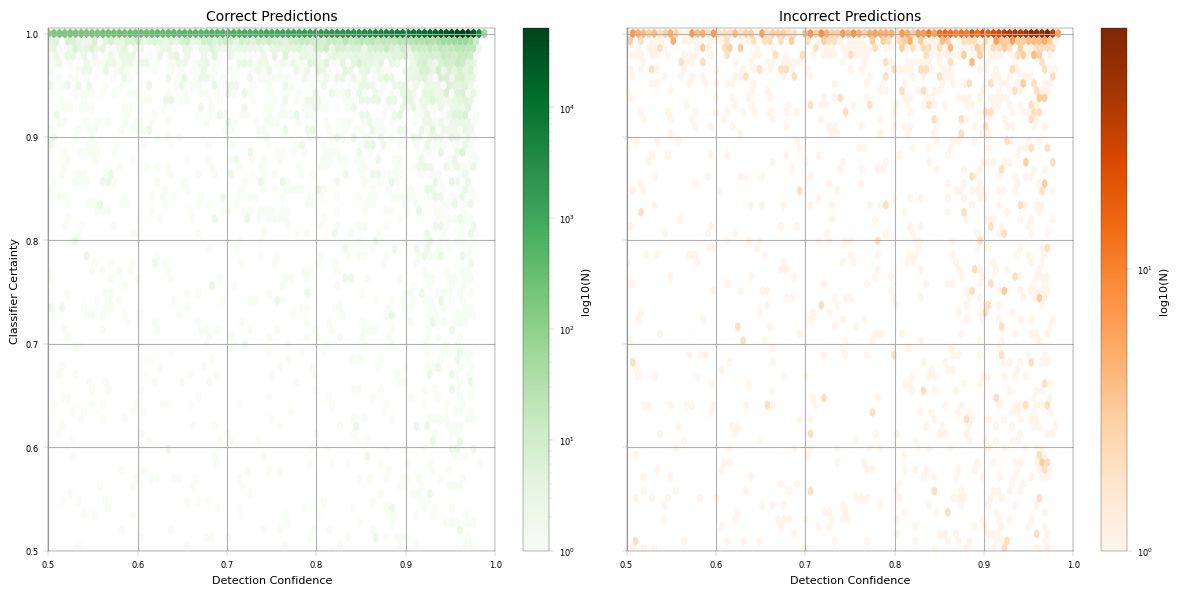

In [69]:
df = eval.best_model.full_predicted_set.copy()

df_correct = df[df['correct'] == True]
df_incorrect = df[df['correct'] == False]

gridsize = 80
linewidths = 0.01
mincnt = 0 

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

hb1 = axes[0].hexbin(
    df_correct['conf'], df_correct['probs_max'],
    gridsize=gridsize, mincnt=mincnt, cmap='Greens', bins='log', linewidths=linewidths
)
axes[0].set_title('Correct Predictions')
axes[0].set_xlabel('Detection Confidence')
axes[0].set_ylabel('Classifier Certainty')

hb2 = axes[1].hexbin(
    df_incorrect['conf'], df_incorrect['probs_max'],
    gridsize=gridsize, mincnt=mincnt, cmap='Oranges', bins='log', linewidths=linewidths
)
axes[1].set_title('Incorrect Predictions')
axes[1].set_xlabel('Detection Confidence')

for ax in axes:
    ax.grid(True)
    ax.set_xlim(0.5, 1)
    ax.set_ylim(0.5, 1.005)

fig.colorbar(hb1, ax=axes[0], orientation='vertical', label='log10(N)')
fig.colorbar(hb2, ax=axes[1], orientation='vertical', label='log10(N)')

plt.tight_layout()
plt.show()


## Checking List of the false prediction with the highest accuracy

In [ ]:
predictions = eval.best_model.get_predictions(filter_by='incorrect', sort='probs_max', fold=0)
idx_to_check = predictions['idx'].tolist()
current_sample = 0


idx: 232461
true_class: 2 - cricetidae
pred_class: 0 - apodemus_sp
classification confidence: 1.0


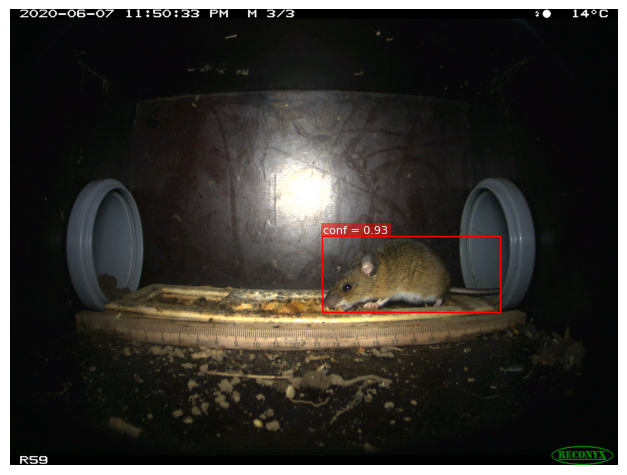

In [87]:
idx = idx_to_check[current_sample]
prediction = predictions.loc[predictions['idx'] == idx].squeeze().to_dict()

true_class = prediction["class_id"]
pred_class = prediction["pred_id"]

print(f'idx: {idx}')
print(f'true_class: {true_class} - {eval.best_model.decoder[true_class]}')
print(f'pred_class: {pred_class} - {eval.best_model.decoder[pred_class]}')
print(f'classification confidence: {prediction["probs_max"]}')
figure = eval.best_model.show_sample(idx)

current_sample += 1


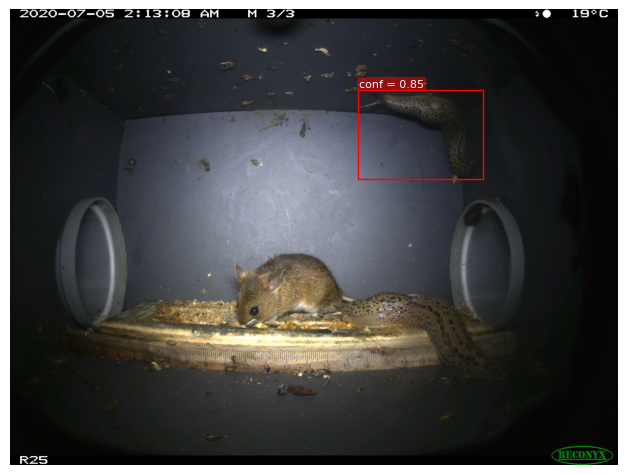

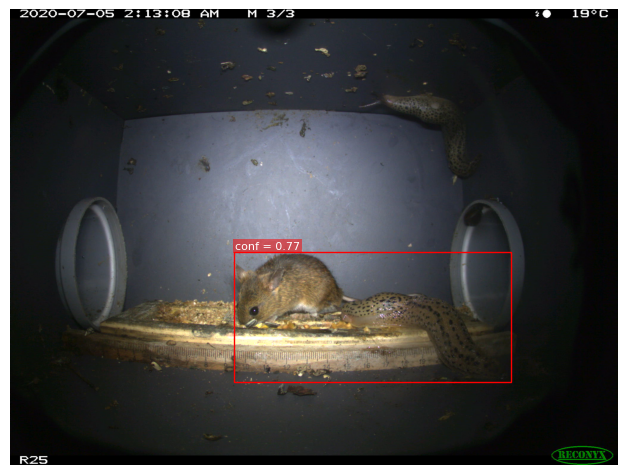

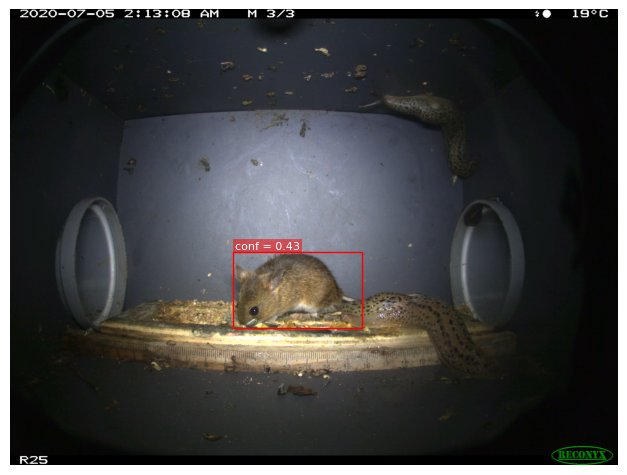

In [78]:
idx = 369260

figures = eval.best_model.show_all_bboxes_for_image(
    idx=idx
    )

